In [1]:
import pandas as pd
import numpy as np

In [2]:
path = 'c:/data/elo/'
train_path = 'train.csv'
test_path = 'test.csv'
historical_transactions_path = 'historical_transactions.csv'
new_merchant_transactions_path = 'new_merchant_transactions.csv'
merchants_path= 'merchants.csv'

In [3]:
%matplotlib inline

In [4]:
import telepot
def send_notify(text):
    with open('../../_access_keys/telegram_token.txt', 'r') as content_file:
        token = content_file.read()
    with open('../../_access_keys/user.txt', 'r') as content_file:
        user = content_file.read()
    try:
        TelegramBot = telepot.Bot(token)
        TelegramBot.sendMessage(int(user), text)
    except:
        pass

In [5]:
from keras.callbacks import Callback
from matplotlib import pyplot as plt
from IPython.display import clear_output
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize=(15,10))
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="validation loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [206]:
from datetime import datetime

In [6]:
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, GlobalMaxPooling1D, GRU, Bidirectional, LSTM, concatenate
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import regularizers

# analyze

In [8]:
train = pd.read_csv(path + train_path)

In [9]:
train.shape

(201917, 6)

In [10]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [11]:
train['feature_3'].unique()

array([1, 0], dtype=int64)

In [76]:
train['is_train'] = True

In [12]:
test = pd.read_csv(path + test_path)

In [13]:
test.shape

(123623, 5)

In [72]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-04,C_ID_0ab67a22ab,3,3,1,NaN
1,2017-01,C_ID_130fd0cbdd,2,3,0,NaN
2,2017-08,C_ID_b709037bc5,5,1,1,NaN
3,2017-12,C_ID_d27d835a9f,2,1,0,NaN
4,2015-12,C_ID_2b5e3df5c2,5,1,1,NaN


In [77]:
test['target'] = np.nan
test['is_train'] = False

In [141]:
train_test = pd.concat((train, test))

## historical_transactions 

In [15]:
historical_transactions = pd.read_csv(path + historical_transactions_path)

In [16]:
historical_transactions.shape

(29112361, 14)

In [129]:
historical_transactions.head(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,0.0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,0.0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,0.0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37


In [292]:
#historical_transactions['subsector_id'].value_counts()

In [58]:
historical_transactions['category_1'].replace({'N':0, 'Y':1}, inplace=True)
historical_transactions['category_3'].replace({'A':0, 'B':1, 'C':2}, inplace=True)
historical_transactions['authorized_flag'].replace({'N':0, 'Y':1}, inplace=True)

In [377]:
sum_purchases = historical_transactions.groupby(['card_id', 'authorized_flag']).agg({'purchase_amount': [min, max, sum, np.median, np.std, 'count', np.mean]}).reset_index()
sum_purchases.columns = ['authorized_flag_' + '_'.join(x) if x[1] != '' else x[0] for x in sum_purchases.columns.ravel()]
sum_purchases.head()

,card_id,authorized_flag,authorized_flag_purchase_amount_min,authorized_flag_purchase_amount_max,authorized_flag_purchase_amount_sum,authorized_flag_purchase_amount_median,authorized_flag_purchase_amount_std,authorized_flag_purchase_amount_count,authorized_flag_purchase_amount_mean
0,C_ID_00007093c1,0,-0.728876,1.507069,-14.401965,-0.569219,0.430059,35,-0.411485
1,C_ID_00007093c1,1,-0.728876,1.206539,-62.443076,-0.596643,0.237426,114,-0.547746
2,C_ID_0001238066,0,-0.596643,-0.596643,-1.789928,-0.596643,0.000000,3,-0.596643
3,C_ID_0001238066,1,-0.734887,0.768095,-70.657273,-0.650122,0.192614,120,-0.588811
4,C_ID_0001506ef0,0,-0.740491,-0.708590,-2.905782,-0.728350,0.016203,4,-0.726445


In [269]:
cities = historical_transactions['city'].unique()
category_1 = historical_transactions['category_1'].unique()
category_3 = historical_transactions['category_3'].unique()
merchant_category_id = historical_transactions['merchant_category_id'].unique()
category_2 = historical_transactions['category_2'].unique()
state_id = historical_transactions['state_id'].unique()
subsector_id = historical_transactions['subsector_id'].unique()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,is_train,purchase_amount_x,purchase_amount_y
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,True,-8.571723,-157.397016
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,True,-1.122886,-208.883450
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,True,-1.338967,-27.828424
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,True,NaN,-49.491364
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,True,20.352809,-69.040465


In [313]:
data.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,is_train,"('purchase_amount', 'min')_x","('purchase_amount', 'max')_x","('purchase_amount', 'sum')_x","('purchase_amount', 'median')_x","('purchase_amount', 'std')_x","(purchase_amount_y, min)","(purchase_amount_y, max)","(purchase_amount_y, sum)","(purchase_amount_y, median)","(purchase_amount_y, std)"
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,True,-0.737892,-0.431922,-8.571723,-0.708755,0.098851,-0.739395,2.258395,-157.397016,-0.697471,0.216518
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,True,-0.740897,1.942838,-1.122886,-0.341192,0.785906,-0.742400,4.630299,-208.883450,-0.709131,0.355554
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,True,-0.701453,-0.637515,-1.338967,-0.669484,0.045211,-0.730138,-0.145847,-27.828424,-0.698868,0.089230
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,True,NaN,NaN,NaN,NaN,NaN,-0.740897,1.445596,-49.491364,-0.707989,0.261624
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,True,-0.512945,7.193041,20.352809,6.992617,4.184950,-0.746156,6.992617,-69.040465,-0.692737,0.737087


## new_merchant_transactions 

In [19]:
new_merchant_transactions = pd.read_csv(path + new_merchant_transactions_path)

In [20]:
new_merchant_transactions.shape

(1963031, 14)

In [51]:
new_merchant_transactions.head()

,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,C_ID_415bb3a509,107,0,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,C_ID_415bb3a509,140,0,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,C_ID_415bb3a509,330,0,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,C_ID_415bb3a509,-1,1,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,C_ID_ef55cf8d4b,-1,1,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [34]:
new_merchant_transactions.drop('authorized_flag', axis=1, inplace=True)

In [49]:
new_merchant_transactions['category_1'].replace({'N':0, 'Y':1}, inplace=True)

In [50]:
new_merchant_transactions['category_1'].value_counts()

0    1899935
1      63096
Name: category_1, dtype: int64

## merchants 

In [23]:
merchants = pd.read_csv(path + merchants_path)

In [24]:
merchants.shape

(334696, 22)

In [25]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [26]:
merchants['most_recent_sales_range'].unique()

array(['E', 'C', 'D', 'A', 'B'], dtype=object)

## processing

In [381]:
data = train_test.merge(sum_purchases[sum_purchases['authorized_flag'] == 0].drop(['authorized_flag'], axis=1), how='left', left_on='card_id', right_on='card_id')
data = data.merge(sum_purchases[sum_purchases['authorized_flag'] == 1].drop(['authorized_flag'], axis=1), how='left', left_on='card_id', right_on='card_id')

In [382]:
data.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,is_train,authorized_flag_purchase_amount_min_x,authorized_flag_purchase_amount_max_x,authorized_flag_purchase_amount_sum_x,...,authorized_flag_purchase_amount_std_x,authorized_flag_purchase_amount_count_x,authorized_flag_purchase_amount_mean_x,authorized_flag_purchase_amount_min_y,authorized_flag_purchase_amount_max_y,authorized_flag_purchase_amount_sum_y,authorized_flag_purchase_amount_median_y,authorized_flag_purchase_amount_std_y,authorized_flag_purchase_amount_count_y,authorized_flag_purchase_amount_mean_y
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,True,-0.737892,-0.431922,-8.571723,...,0.098851,13.0,-0.659363,-0.739395,2.258395,-157.397016,-0.697471,0.216518,247,-0.637235
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,True,-0.740897,1.942838,-1.122886,...,0.785906,11.0,-0.102081,-0.742400,4.630299,-208.883450,-0.709131,0.355554,339,-0.616175
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,True,-0.701453,-0.637515,-1.338967,...,0.045211,2.0,-0.669484,-0.730138,-0.145847,-27.828424,-0.698868,0.089230,41,-0.678742
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,True,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.740897,1.445596,-49.491364,-0.707989,0.261624,77,-0.642745
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,True,-0.512945,7.193041,20.352809,...,4.184950,5.0,4.070562,-0.746156,6.992617,-69.040465,-0.692737,0.737087,128,-0.539379


In [395]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_1,325540.0,0.526703,0.296820,0.000000,2.500000e-01,5.000000e-01,7.500000e-01,1.000000
feature_2,325540.0,0.372019,0.375270,0.000000,0.000000e+00,5.000000e-01,5.000000e-01,1.000000
feature_3,325540.0,0.565116,0.495742,0.000000,0.000000e+00,1.000000e+00,1.000000e+00,1.000000
target,325540.0,-0.244154,3.038513,-33.219281,-3.029545e-01,0.000000e+00,2.264410e-01,17.965068
authorized_flag_purchase_amount_min_x,325540.0,0.000003,0.001753,0.000000,1.997501e-09,5.725001e-09,3.395750e-08,1.000000
authorized_flag_purchase_amount_max_x,325540.0,0.000009,0.001768,0.000000,1.797500e-08,5.998750e-08,1.242625e-07,1.000000
authorized_flag_purchase_amount_sum_x,325540.0,0.000177,0.001768,0.000000,1.676520e-04,1.681991e-04,1.685284e-04,1.000000
authorized_flag_purchase_amount_median_x,325540.0,0.000003,0.001753,0.000000,6.435001e-09,1.724750e-08,9.174750e-08,1.000000
authorized_flag_purchase_amount_std_x,325540.0,0.000128,0.005214,0.000000,0.000000e+00,4.528366e-07,2.040304e-06,1.000000
authorized_flag_purchase_amount_count_x,325540.0,0.005120,0.007892,0.000000,6.622517e-04,2.649007e-03,6.622517e-03,1.000000


In [384]:
data.fillna(0, inplace=True)

In [386]:
target_columns = [str(i) for i in data.columns]
target_columns.remove('target')
target_columns.remove('is_train')
target_columns.remove('card_id')
target_columns.remove('first_active_month')

In [387]:
scaler_columns = target_columns
for i in scaler_columns:
    data[i] -= data[i].min()
    data[i] /= data[i].max()

# train

In [388]:
X = data[data['is_train']][target_columns]

In [389]:
y = data[data['is_train']]['target']

In [390]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [391]:
X_train.describe()

,feature_1,feature_2,feature_3,authorized_flag_purchase_amount_min_x,authorized_flag_purchase_amount_max_x,authorized_flag_purchase_amount_sum_x,authorized_flag_purchase_amount_median_x,authorized_flag_purchase_amount_std_x,authorized_flag_purchase_amount_count_x,authorized_flag_purchase_amount_mean_x,authorized_flag_purchase_amount_min_y,authorized_flag_purchase_amount_max_y,authorized_flag_purchase_amount_sum_y,authorized_flag_purchase_amount_median_y,authorized_flag_purchase_amount_std_y,authorized_flag_purchase_amount_count_y,authorized_flag_purchase_amount_mean_y
count,161533.000000,161533.000000,161533.000000,1.615330e+05,1.615330e+05,161533.000000,1.615330e+05,1.615330e+05,161533.000000,1.615330e+05,161533.000000,161533.000000,161533.000000,161533.000000,161533.000000,161533.000000,161533.000000
mean,0.526078,0.372726,0.564665,6.500604e-06,1.249772e-05,0.000180,6.624614e-06,1.322679e-04,0.005115,7.216725e-06,0.000610,0.003848,0.282693,0.003416,0.004016,0.019323,0.005593
std,0.296627,0.375696,0.495802,2.488840e-03,2.499573e-03,0.002499,2.488878e-03,5.449464e-03,0.007869,2.489076e-03,0.003485,0.007645,0.007025,0.007740,0.007971,0.024096,0.010409
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000004,0.091892,0.000000,0.000000,0.000000,0.000040
25%,0.250000,0.000000,0.000000,2.000000e-09,1.788250e-08,0.000168,6.435000e-09,0.000000e+00,0.000662,9.365833e-09,0.000110,0.000872,0.281327,0.001109,0.000993,0.005097,0.001766
50%,0.500000,0.500000,1.000000,5.725001e-09,5.974750e-08,0.000168,1.717500e-08,4.532491e-07,0.002649,2.599750e-08,0.000246,0.001806,0.284899,0.001925,0.001999,0.011165,0.003184
75%,0.750000,0.500000,1.000000,3.372500e-08,1.242625e-07,0.000169,9.140000e-08,2.031033e-06,0.006623,1.242625e-07,0.000523,0.004184,0.286630,0.003550,0.004331,0.024029,0.006004
max,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,0.434479,0.677627,0.887504,0.736378,0.615291,1.000000


In [392]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [393]:
def create_model():
    #build Keras model
    
    x_input = Input(shape=X_train.shape[1:], dtype='float32')

    x_layer = Dense(X_train.shape[-1], activation="relu", kernel_initializer="normal")(x_input)
    x_layer = Dense(X_train.shape[-1], activation="relu", kernel_initializer="normal")(x_layer)
    x_layer = Dense(X_train.shape[-1], activation="relu", kernel_initializer="normal")(x_layer)
    x_layer = Dense(X_train.shape[-1], activation="relu", kernel_initializer="normal")(x_layer)
    x_layer = Dense(1, activation="relu", kernel_initializer="normal")(x_layer)
    

    model = Model(x_input, x_layer)
    model.compile(loss='mean_squared_error', metrics=['mae'], optimizer='rmsprop')
    return model

In [394]:
count_epochs = 100
model = create_model()
early_stopping_monitor = EarlyStopping(patience=10)
history = model.fit(np.array(X_train), np.array(y_train), batch_size = 64, epochs = count_epochs, verbose=1, validation_split=0.2, callbacks=[early_stopping_monitor])

Train on 129226 samples, validate on 32307 samples
Epoch 1/100
129226/129226 [==============================] - 3s 24us/step - loss: 14.9865 - mean_absolute_error: 1.5449 - val_loss: 14.7089 - val_mean_absolute_error: 1.5313
Epoch 2/100
129226/129226 [==============================] - 3s 20us/step - loss: 14.9865 - mean_absolute_error: 1.5449 - val_loss: 14.7089 - val_mean_absolute_error: 1.5313
Epoch 3/100
129226/129226 [==============================] - 3s 20us/step - loss: 14.9865 - mean_absolute_error: 1.5449 - val_loss: 14.7089 - val_mean_absolute_error: 1.5313
Epoch 4/100
129226/129226 [==============================] - 3s 20us/step - loss: 14.9865 - mean_absolute_error: 1.5449 - val_loss: 14.7089 - val_mean_absolute_error: 1.5313
Epoch 5/100
129226/129226 [==============================] - 3s 20us/step - loss: 14.9865 - mean_absolute_error: 1.5449 - val_loss: 14.7089 - val_mean_absolute_error: 1.5313
Epoch 6/100
129226/129226 [==============================] - 3s 20us/step - los

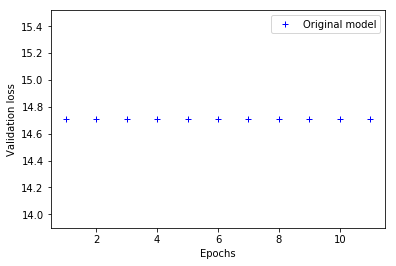

In [396]:
history_gr = history.history['val_loss']
epochs = range(1, len(history_gr) + 1)
import matplotlib.pyplot as plt

plt.plot(epochs, history_gr, 'b+', label='Original model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

In [397]:
model.evaluate(np.array(X_test), np.array(y_test))

40384/40384 [==============================] - 1s 21us/step


[15.182110592699278, 1.5425792284510593]

In [288]:
X_val = data[~data['is_train']][target_columns]

In [289]:
predict = model.predict(np.array(X_val))

In [290]:
pd.DataFrame({'card_id':list(data[~data['is_train']]['card_id']), 'target':predict.reshape(len(predict))}).to_csv('output/predict_{}.csv'.format(datetime.now().strftime("%Y-%m-%d_%H_%M_%S")), index=False)